# LSTM
Cell Line A549. LSTM 135. Coding 1-2K. 

Acc 68%, Prec 70%, Recall 71%, F1 70%.

In [12]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2023-01-17 18:02:17.737769
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [13]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
RCELLS=32
DCELLS=16
EPOCHS=3
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=1000
MAXLEN=2000   

In [14]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [15]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [16]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
CELL_LINE = 0
print('Use only this cell line',all_cell_lines[CELL_LINE])

Use only this cell line A549


## Data Load

In [17]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        overall_sum = 0
        overall_count = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    rci_str = fields[cell_line+1]
                    if rci_str != "nan":
                        # Convert string nan to float(nan)
                        rci_val = float(rci_str)
                        gene_to_rci[gene_id] = rci_val
                        overall_sum += rci_val
                        overall_count += 1
        overall_mean = overall_sum / overall_count
        print('Number of RCI values',overall_count)
        print('Mean RCI value',overall_mean)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [18]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Num labels:',len(labels))
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num sequences:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2023-01-17 18:02:18.917414
Load RCI values...
Number of RCI values 13000
Mean RCI value -0.036765961332307674
Num RCI: 13000
Example RCI: [('ENSG00000000003', 1.85734), ('ENSG00000000005', 5.88264), ('ENSG00000000419', 2.58954)]
Load genes...
2023-01-17 18:02:18.948939
Load sequence...
2023-01-17 18:02:29.353571
Num IDs: 13143
Example IDs: [('ENSG00000186827', 'ENST00000379236.4'), ('ENSG00000127054', 'ENST00000620829.4'), ('ENSG00000235098', 'ENST00000520296.5'), ('ENSG00000187730', 'ENST00000638411.1')]
Count 6959 ones out of 13143 labels.
Num labels: 13143
Example labels: [0, 0, 0, 0]
Num sequences: 13143
Example sequence: [60, 238, 182, 213, 81, 67, 11, 43, 171, 169, 164, 142, 54, 216, 95, 122, 229, 147, 75, 44, 175, 186, 229, 148, 78, 54, 216, 94, 118, 215, 89, 100, 142, 56, 223, 122, 231, 153, 98, 136, 31, 122, 230, 150, 87, 91, 107, 170, 168, 159, 122, 230, 151, 89, 97, 132, 13, 52, 206, 54, 216, 94, 118, 214, 86, 87, 91, 108, 175, 185, 225, 130, 6, 23, 91, 107, 171, 171, 170, 1

## Model

In [19]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=False)   
    rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=True) )
    dens_layer = TimeDistributed(Dense(DCELLS))
    flat_layer = Flatten()
    drop_layer = Dropout(0.5) # this model will rely on specific time points not patterns
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    #rnn.add(mask_layer)
    rnn.add(embed_layer)
    rnn.add(rnn1_layer)
    rnn.add(dens_layer)
    rnn.add(flat_layer)
    rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [20]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2023-01-17 18:02:29.395732
COMPILE
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 1997, 4)           1028      
                                                                 
 bidirectional_6 (Bidirectio  (None, 1997, 64)         9472      
 nal)                                                            
                                                                 
 time_distributed_6 (TimeDis  (None, 1997, 16)         1040      
 tributed)                                                       
                                                                 
 flatten_6 (Flatten)         (None, 31952)             0         
                                                                 
 dropout_6 (Dropout)         (None, 31952)             0         
                                                                 
 dense_13 (Dense)  

## Training

In [21]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = threshold
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2023-01-17 18:02:31.787318
2023-01-17 18:02:31.787453
splitting
Fold 1
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10521, 1997) (10521, 1)
Valid sizes (2622, 1997) (2622, 1)
Train set ones/size 5609 / 10521
Valid set ones/size 1350 / 2622
BUILD MODEL
COMPILE
FIT
2023-01-17 18:02:33.777496
Epoch 1/3
329/329 [==============================] - 40s 113ms/step - loss: 0.6184 - accuracy: 0.6536 - val_loss: 0.6033 - val_accuracy: 0.6789
Epoch 2/3
329/329 [==============================] - 37s 112ms/step - loss: 0.5809 - accuracy: 0.6990 - val_loss: 0.6008 - val_accuracy: 0.6812
Epoch 3/3
329/329 [==============================] - 37s 113ms/step - loss: 0.5557 - accuracy: 0.7189 - val_loss: 0.6186 - val_accuracy: 0.6720


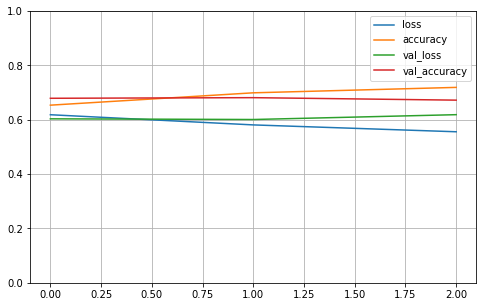

Compute valiation accuracy
2023-01-17 18:04:28.356141
Range of scores: 0.017407134 to 0.975446
Predicted zeros and ones 1474 1148
Accuracy: 67.20% Precision: 71.34% Recall: 60.67% F1: 65.57%
2023-01-17 18:04:34.127581
Fold 2
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10474, 1997) (10474, 1)
Valid sizes (2669, 1997) (2669, 1)
Train set ones/size 5478 / 10474
Valid set ones/size 1481 / 2669
BUILD MODEL
COMPILE
FIT
2023-01-17 18:04:36.172070
Epoch 1/3
328/328 [==============================] - 41s 116ms/step - loss: 0.6137 - accuracy: 0.6611 - val_loss: 0.6207 - val_accuracy: 0.6830
Epoch 2/3
328/328 [==============================] - 37s 114ms/step - loss: 0.5747 - accuracy: 0.7096 - val_loss: 0.5934 - val_accuracy: 0.6804
Epoch 3/3
328/328 [==============================] - 37s 114ms/step - loss: 0.5489 - accuracy: 0.7291 - val_loss: 0.6076 - val_accuracy: 0.6722


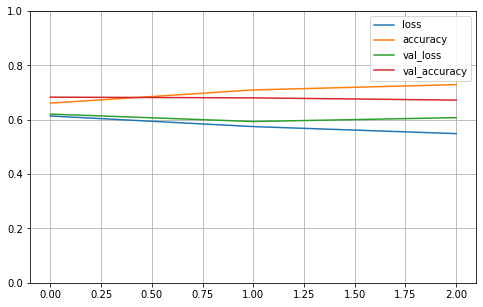

Compute valiation accuracy
2023-01-17 18:06:32.656865
Range of scores: 0.025442498 to 0.9766424
Predicted zeros and ones 1023 1646
Accuracy: 67.22% Precision: 68.41% Recall: 76.03% F1: 72.02%
2023-01-17 18:06:36.969746
Fold 3
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10563, 1997) (10563, 1)
Valid sizes (2580, 1997) (2580, 1)
Train set ones/size 5669 / 10563
Valid set ones/size 1290 / 2580
BUILD MODEL
COMPILE
FIT
2023-01-17 18:06:38.951429
Epoch 1/3
331/331 [==============================] - 40s 114ms/step - loss: 0.6162 - accuracy: 0.6604 - val_loss: 0.6057 - val_accuracy: 0.6895
Epoch 2/3
331/331 [==============================] - 37s 110ms/step - loss: 0.5791 - accuracy: 0.7043 - val_loss: 0.6155 - val_accuracy: 0.6853
Epoch 3/3
331/331 [==============================] - 37s 110ms/step - loss: 0.5541 - accuracy: 0.7202 - val_loss: 0.6219 - val_accuracy: 0.6977


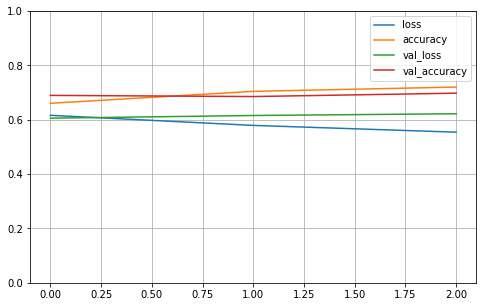

Compute valiation accuracy
2023-01-17 18:08:32.813377
Range of scores: 0.009255875 to 0.98009163
Predicted zeros and ones 1366 1214
Accuracy: 69.77% Precision: 71.00% Recall: 66.82% F1: 68.85%
2023-01-17 18:08:38.591784
Fold 4
Training example
[ 60 238 182 ...   0   0   0]
Train sizes (10478, 1997) (10478, 1)
Valid sizes (2665, 1997) (2665, 1)
Train set ones/size 5589 / 10478
Valid set ones/size 1370 / 2665
BUILD MODEL
COMPILE
FIT
2023-01-17 18:08:40.516547
Epoch 1/3
328/328 [==============================] - 40s 113ms/step - loss: 0.6117 - accuracy: 0.6636 - val_loss: 0.6012 - val_accuracy: 0.6856
Epoch 2/3
328/328 [==============================] - 37s 112ms/step - loss: 0.5899 - accuracy: 0.6925 - val_loss: 0.6087 - val_accuracy: 0.6867
Epoch 3/3
328/328 [==============================] - 37s 113ms/step - loss: 0.5699 - accuracy: 0.7054 - val_loss: 0.6160 - val_accuracy: 0.6758


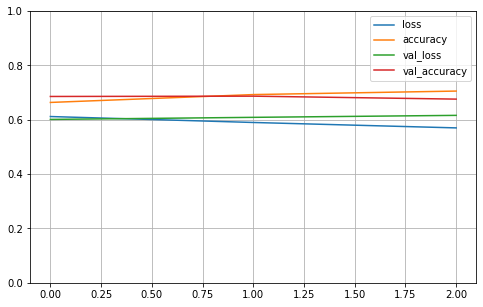

Compute valiation accuracy
2023-01-17 18:10:34.647235
Range of scores: 0.041223403 to 0.96456814
Predicted zeros and ones 1253 1412
Accuracy: 67.58% Precision: 67.92% Recall: 70.00% F1: 68.94%
2023-01-17 18:10:38.976679
Fold 5
Training example
[169 161 129 ...   0   0   0]
Train sizes (10536, 1997) (10536, 1)
Valid sizes (2607, 1997) (2607, 1)
Train set ones/size 5491 / 10536
Valid set ones/size 1468 / 2607
BUILD MODEL
COMPILE
FIT
2023-01-17 18:10:40.918816
Epoch 1/3
330/330 [==============================] - 41s 113ms/step - loss: 0.6249 - accuracy: 0.6460 - val_loss: 0.5848 - val_accuracy: 0.7039
Epoch 2/3
330/330 [==============================] - 36s 111ms/step - loss: 0.5893 - accuracy: 0.6905 - val_loss: 0.5754 - val_accuracy: 0.7135
Epoch 3/3
330/330 [==============================] - 36s 110ms/step - loss: 0.5684 - accuracy: 0.7090 - val_loss: 0.5793 - val_accuracy: 0.7035


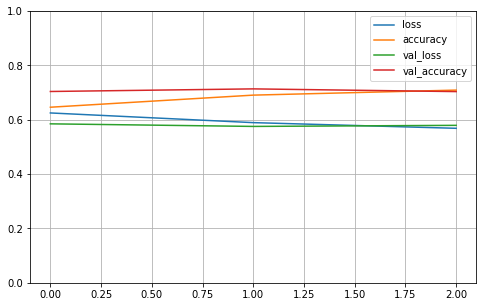

Compute valiation accuracy
2023-01-17 18:12:34.801317
Range of scores: 0.05023387 to 0.986371
Predicted zeros and ones 924 1683
Accuracy: 70.35% Precision: 70.65% Recall: 80.99% F1: 75.47%
2023-01-17 18:12:39.034896

Cross validation 5 folds 3 epochs
 accuracy mean 68.42% +/- 1.35
 precision mean 69.86% +/- 1.41
 recall mean 70.90% +/- 7.08
 F1 mean 70.17% +/- 3.34
2023-01-17 18:12:39.038982


In [22]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())